<a href="https://colab.research.google.com/github/darisoy/EE596_Project/blob/main/testing_CNNAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐍 Python setup

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as T
from PIL import Image
import cv2
import numpy as np
import glob
import random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📀 Get the data

In [2]:
!git clone https://github.com/darisoy/EE596_Project.git

Cloning into 'EE596_Project'...
remote: Enumerating objects: 3911, done.
remote: Counting objects: 100% (3911/3911), done.
remote: Compressing objects: 100% (3907/3907), done.
remote: Total 3911 (delta 17), reused 3872 (delta 2), pack-reused 0
Receiving objects: 100% (3911/3911), 60.39 MiB | 30.31 MiB/s, done.
Resolving deltas: 100% (17/17), done.


# 😷 Get random mask

In [78]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, min_size=1000).to(device)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [99]:
def mask_out(img, output, thres=0.7):
    for idx, box in enumerate(output[0]['boxes'].tolist()):
        score = output[0]['scores'][idx].tolist()
        if score > thres: 
            mask = output[0]['masks'][idx][0].detach().cpu().numpy()
            mask[mask > 0.2] = 1
            mask = cv2.resize(mask, dsize=(img.shape[1], img.shape[0]))
            visMask = (255-(mask * 255)).astype("uint8")
            img = cv2.bitwise_and(img, img, mask=visMask)
    return img

In [100]:
trf = T.Compose([T.ToTensor()])
def random_mask(i):
    maskname = '/content/EE596_Project/data/furnished/'+str(random.randint(0, 1226))+'.jpg'
    imagename = '/content/EE596_Project/data/empty/'+str(i)+'.jpg'
    model.eval()
    try:
        image = Image.open(glob.glob(maskname)[0])
    except:
        print(maskname)
    input = trf(image)
    input = torch.unsqueeze(input, 0).to(device)
    output = model(input)
    return cv2.imread(imagename), mask_out(cv2.imread(imagename), output)

In [ ]:
# for i in random.sample(range(0, 1000), 1):
for i in range(0, 1329):
    orig, masked = random_mask(i)
    # cv2_imshow(orig)
    # cv2_imshow(masked)
    cv2.imwrite(('/content/masked/%d.jpg' % i), masked)    

# 🎨 Fill in the gaps

## CNN autoencoder

In [95]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 2, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [115]:
EPOCHS = 200
LEARNING_RATE = 0.1
MOMENTUM = 0.5
criterion = nn.MSELoss()
filler = ConvAutoEncoder().to(device)
optimizer = optim.SGD(filler.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [116]:
for epoch in range(EPOCHS):
    filler.train()
    total_loss = 0.0
    for i in tqdm(range(1328)):
        # orig, masked = random_mask(i)
        orig = cv2.imread('/content/EE596_Project/data/empty/'+str(i)+'.jpg')
        masked = cv2.imread('/content/EE596_Project/data/masked_empty/'+str(i)+'.jpg')
        optimizer.zero_grad()
        masked = torch.tensor(np.transpose(masked)).to(device) / 255.0
        pred = filler(masked.unsqueeze(dim=0))
        orig = cv2.resize(orig, dsize=(pred.shape[2], pred.shape[3]))
        orig = torch.tensor(np.transpose(orig)).to(device) / 255.0
        loss = criterion(pred, orig.unsqueeze(dim=0)) 
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    print('[Epoch: %d]\tLoss: %.6f' % (epoch, (total_loss/1328)))


[Epoch: 0]	Loss: 0.052702



[Epoch: 1]	Loss: 0.038176



[Epoch: 2]	Loss: 0.029259



[Epoch: 3]	Loss: 0.023741



[Epoch: 4]	Loss: 0.019307



[Epoch: 5]	Loss: 0.018287



[Epoch: 6]	Loss: 0.017835



[Epoch: 7]	Loss: 0.017569



[Epoch: 8]	Loss: 0.017316



[Epoch: 9]	Loss: 0.017123



[Epoch: 10]	Loss: 0.016956



[Epoch: 11]	Loss: 0.016813



[Epoch: 12]	Loss: 0.016705



[Epoch: 13]	Loss: 0.016595



[Epoch: 14]	Loss: 0.016507



[Epoch: 15]	Loss: 0.016410



[Epoch: 16]	Loss: 0.016319



[Epoch: 17]	Loss: 0.016219



[Epoch: 18]	Loss: 0.016128



[Epoch: 19]	Loss: 0.016014



[Epoch: 20]	Loss: 0.015896



[Epoch: 21]	Loss: 0.015773



[Epoch: 22]	Loss: 0.015676



[Epoch: 23]	Loss: 0.015616



[Epoch: 24]	Loss: 0.015538



[Epoch: 25]	Loss: 0.015487



[Epoch: 26]	Loss: 0.015429



[Epoch: 27]	Loss: 0.015377



[Epoch: 28]	Loss: 0.015322



[Epoch: 29]	Loss: 0.015243



[Epoch: 30]	Loss: 0.015168



[Epoch: 31]	Loss: 0.015054



[Epoch: 32]	Loss: 0.014873



[Epoch: 33]	Loss: 0.014692



[Epoch: 34]	Loss: 0.014520



[Epoch: 35]	Loss: 0.014219



[Epoch: 36]	Loss: 0.014009



[Epoch: 37]	Loss: 0.013755



[Epoch: 38]	Loss: 0.013537



[Epoch: 39]	Loss: 0.013410



[Epoch: 40]	Loss: 0.013340



[Epoch: 41]	Loss: 0.013273



[Epoch: 42]	Loss: 0.013238



[Epoch: 43]	Loss: 0.013208



[Epoch: 44]	Loss: 0.013169



[Epoch: 45]	Loss: 0.013143



[Epoch: 46]	Loss: 0.013119



[Epoch: 47]	Loss: 0.013094



[Epoch: 48]	Loss: 0.013083



[Epoch: 49]	Loss: 0.013059



[Epoch: 50]	Loss: 0.013017



[Epoch: 51]	Loss: 0.013008



[Epoch: 52]	Loss: 0.013030



[Epoch: 53]	Loss: 0.012980



[Epoch: 54]	Loss: 0.012982



[Epoch: 55]	Loss: 0.012974



[Epoch: 56]	Loss: 0.012958



[Epoch: 57]	Loss: 0.012927



[Epoch: 58]	Loss: 0.012936



[Epoch: 59]	Loss: 0.012902



[Epoch: 60]	Loss: 0.012913



[Epoch: 61]	Loss: 0.012892



[Epoch: 62]	Loss: 0.012874



[Epoch: 63]	Loss: 0.012882



[Epoch: 64]	Loss: 0.012863



[Epoch: 65]	Loss: 0.012853



[Epoch: 66]	Loss: 0.012843



[Epoch: 67]	Loss: 0.012834



[Epoch: 68]	Loss: 0.012825



[Epoch: 69]	Loss: 0.012813



[Epoch: 70]	Loss: 0.012819



[Epoch: 71]	Loss: 0.012797



[Epoch: 72]	Loss: 0.012789



[Epoch: 73]	Loss: 0.012781



[Epoch: 74]	Loss: 0.012772



[Epoch: 75]	Loss: 0.012766



[Epoch: 76]	Loss: 0.012758



[Epoch: 77]	Loss: 0.012752



[Epoch: 78]	Loss: 0.012745



[Epoch: 79]	Loss: 0.012756



[Epoch: 80]	Loss: 0.012735



[Epoch: 81]	Loss: 0.012735



[Epoch: 82]	Loss: 0.012743



[Epoch: 83]	Loss: 0.012727



[Epoch: 84]	Loss: 0.012722



[Epoch: 85]	Loss: 0.012719



[Epoch: 86]	Loss: 0.012693



[Epoch: 87]	Loss: 0.012699



[Epoch: 88]	Loss: 0.012740



[Epoch: 89]	Loss: 0.012708



[Epoch: 90]	Loss: 0.012720



[Epoch: 91]	Loss: 0.012706



[Epoch: 92]	Loss: 0.012696



[Epoch: 93]	Loss: 0.012678



[Epoch: 94]	Loss: 0.012628



[Epoch: 95]	Loss: 0.012621



[Epoch: 96]	Loss: 0.012652



[Epoch: 97]	Loss: 0.012652



[Epoch: 98]	Loss: 0.012615



[Epoch: 99]	Loss: 0.012634



[Epoch: 100]	Loss: 0.012620


KeyboardInterrupt: ignored

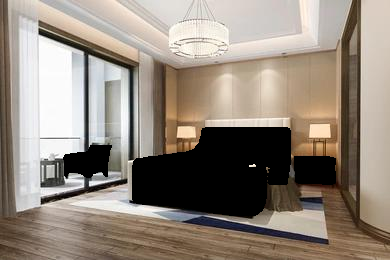

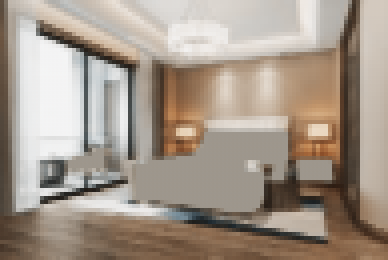

In [120]:
filler.eval()
# orig, masked = random_mask(1)
# cv2_imshow(orig)
masked = detect_objects('/content/EE596_Project/data/furnished/'+str(4)+'.jpg')
cv2_imshow(masked)
masked = torch.tensor(np.transpose(masked)).to(device) / 255.0
pred = filler(masked.unsqueeze(dim=0))
pred = np.transpose(pred.squeeze(dim=0).detach().cpu().numpy() * 255.0)
cv2_imshow(pred)

## Linear autoencoder

In [5]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )
        # self.fc1 = nn.Linear(227*227, 10000)
        # self.fc2 = nn.Linear(10000, 1000)
        # self.fc3 = nn.Linear(1000, 200)
        # self.fc4 = nn.Linear(200, 1000)
        # self.fc5 = nn.Linear(1000, 10000)
        # self.fc6 = nn.Linear(10000, 227*227)

    def forward_encoder(self, x):
        x = x / 255.0
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x
    
    def forward_decoder(self, x):
        x = F.leaky_relu(self.fc4(x))
        x = F.leaky_relu(self.fc5(x))
        x = self.fc6(x)
        return x * 255
    
    def forward(self, x):
        # x = self.forward_encoder(x)
        # x = self.forward_decoder(x)   
        x = x/255.0
        x = self.encoder(x)
        x = self.decoder(x)
        return x*255

In [35]:
EPOCHS = 200
LEARNING_RATE = 0.1
MOMENTUM = 0.5
criterion = nn.MSELoss()
filler = Net().to(device)
optimizer = optim.SGD(filler.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [85]:
for epoch in range(EPOCHS):
    filler.train()
    total_loss = 0.0
    for i in tqdm(random.sample(range(1328), 1328)):
        orig = Image.open('/content/EE596_Project/data/empty/'+str(i)+'.jpg').convert('LA')
        orig = orig.resize([28, 28])
        orig = np.squeeze(np.array(orig)[:, :, 0])
        orig = np.reshape(orig, (1, 28*28))
        orig = torch.tensor(orig).to(device)

        masked = Image.open('/content/EE596_Project/data/masked_empty/'+str(i)+'.jpg').convert('LA')
        masked = masked.resize([28, 28])
        masked = np.squeeze(np.array(masked)[:, :, 0])
        masked = np.reshape(masked, (1, 28*28))
        masked = torch.tensor(masked).to(device)

        optimizer.zero_grad()
        pred = filler(masked)
        loss = criterion(pred/255.0, orig/255.0) 
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    print('[Epoch: %d]\tLoss: %.6f' % (epoch, (total_loss/1328)))


[Epoch: 0]	Loss: 0.009357



[Epoch: 1]	Loss: 0.009348



[Epoch: 2]	Loss: 0.009341



[Epoch: 3]	Loss: 0.009336



[Epoch: 4]	Loss: 0.009315



[Epoch: 5]	Loss: 0.009319



[Epoch: 6]	Loss: 0.009299



[Epoch: 7]	Loss: 0.009305



[Epoch: 8]	Loss: 0.009291



[Epoch: 9]	Loss: 0.009279



[Epoch: 10]	Loss: 0.009271



[Epoch: 11]	Loss: 0.009266



[Epoch: 12]	Loss: 0.009252



[Epoch: 13]	Loss: 0.009256



[Epoch: 14]	Loss: 0.009226



[Epoch: 15]	Loss: 0.009231



[Epoch: 16]	Loss: 0.009222



[Epoch: 17]	Loss: 0.009213



[Epoch: 18]	Loss: 0.009204



[Epoch: 19]	Loss: 0.009194



[Epoch: 20]	Loss: 0.009186



[Epoch: 21]	Loss: 0.009177



[Epoch: 22]	Loss: 0.009176



[Epoch: 23]	Loss: 0.009164



[Epoch: 24]	Loss: 0.009154



[Epoch: 25]	Loss: 0.009155



[Epoch: 26]	Loss: 0.009142



[Epoch: 27]	Loss: 0.009139



[Epoch: 28]	Loss: 0.009131



[Epoch: 29]	Loss: 0.009118



[Epoch: 30]	Loss: 0.009120



[Epoch: 31]	Loss: 0.009110



[Epoch: 32]	Loss: 0.009091



[Epoch: 33]	Loss: 0.009091



[Epoch: 34]	Loss: 0.009080



[Epoch: 35]	Loss: 0.009069



[Epoch: 36]	Loss: 0.009065



[Epoch: 37]	Loss: 0.009049



[Epoch: 38]	Loss: 0.009038



[Epoch: 39]	Loss: 0.009028



[Epoch: 40]	Loss: 0.009021



[Epoch: 41]	Loss: 0.009019



[Epoch: 42]	Loss: 0.009004



[Epoch: 43]	Loss: 0.008998



[Epoch: 44]	Loss: 0.008992



[Epoch: 45]	Loss: 0.008975



[Epoch: 46]	Loss: 0.008967



[Epoch: 47]	Loss: 0.008964



[Epoch: 48]	Loss: 0.008949



[Epoch: 49]	Loss: 0.008944


(-0.5, 27.5, 27.5, -0.5)

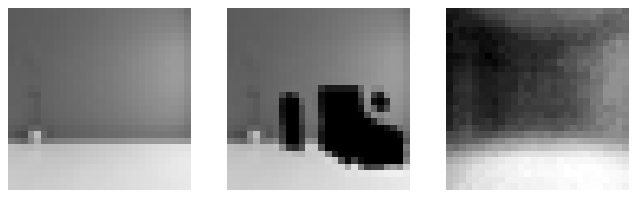

In [87]:
plt.figure(figsize=(10, 8), dpi=80)
filler.eval()
i = 140
orig = Image.open('/content/EE596_Project/data/empty/'+str(i)+'.jpg').convert('LA')
orig = orig.resize([28, 28])
plt.subplot(1, 3, 1)
plt.imshow(orig)
plt.axis('off')
orig = np.squeeze(np.array(orig)[:, :, 0])
orig = np.reshape(orig, (1, 28*28))
orig = torch.tensor(orig).to(device)

masked = Image.open('/content/EE596_Project/data/masked_empty/'+str(i)+'.jpg').convert('LA')
masked = masked.resize([28, 28])
plt.subplot(1, 3, 2)
plt.imshow(masked)
plt.axis('off')
masked = np.squeeze(np.array(masked)[:, :, 0])
masked = np.reshape(masked, (1, 28*28))
masked = torch.tensor(masked).to(device)

pred = filler(masked)
pred = pred.view(1,28,28)
pred = pred.permute(1,2,0).squeeze(2)
pred = pred.detach().cpu().numpy()
plt.subplot(1, 3, 3)
plt.imshow(pred, cmap='gray')
plt.axis('off')


In [79]:
def mask_out(img, output, thres=0.7):
    for idx, box in enumerate(output[0]['boxes'].tolist()):
        score = output[0]['scores'][idx].tolist()
        if score > thres: 
            mask = output[0]['masks'][idx][0].detach().cpu().numpy()
            mask[mask > 0.2] = 1
            visMask = (255-(mask * 255)).astype("uint8")
            img = cv2.bitwise_and(img, img, mask=visMask)
    cv2_imshow(img)
    return img

trf = T.Compose([T.ToTensor()])
def detect_objects(imagename):
    model.eval()
    image = Image.open(glob.glob(imagename)[0])
    input = trf(image)
    input = torch.unsqueeze(input, 0).to(device)
    output = model(input)
    img = cv2.imread(imagename)
    return mask_out(img, output)

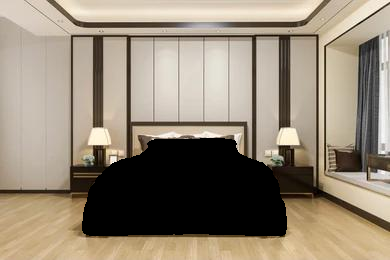

(-0.5, 27.5, 27.5, -0.5)

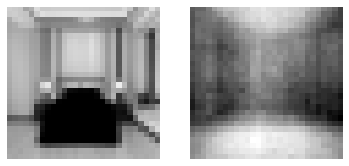

In [94]:
i = 3
im = detect_objects('/content/EE596_Project/data/furnished/'+str(i)+'.jpg')
im = Image.fromarray(im).convert('LA')
im = im.resize([28, 28])
plt.subplot(1, 2, 1)
plt.imshow(im,)
plt.axis('off')
im = np.squeeze(np.array(im)[:, :, 0])
im = np.reshape(im, (1, 28*28))
im = torch.tensor(im).to(device)

pred = filler(im)
pred = pred.view(1,28,28)
pred = pred.permute(1,2,0).squeeze(2)
pred = pred.detach().cpu().numpy()
plt.subplot(1, 2, 2)
plt.imshow(pred, cmap='gray')
plt.axis('off')